Some preliminaries

In [4]:
import pandas as pd
import json

with open("../data/mgnify_data/MGYS00003619__metadata.json") as f:
    test_metadata = json.load(f)
test_metadata = pd.DataFrame(test_metadata["metadata"])
print(test_metadata.index)
# print(test_metadata.loc["disease status__biosamples"].value_counts(dropna=False))
print(test_metadata.loc["Health state__elixir"].value_counts(dropna=False))
print(test_metadata.loc["Disease name__elixir"].value_counts(dropna=False))


Index(['geographic location (country and/or sea,region)',
       'environment (biome)', 'environment (feature)',
       'environment (material)', 'environmental package', 'host taxid',
       'instrument model', 'last update date', 'host scientific name',
       'biosample_id', 'sample_id', 'latitude', 'longitude', 'species',
       'env biome__biosamples', 'env feature__biosamples',
       'env_material__biosamples', 'geo loc name__biosamples',
       'host__biosamples', 'host age__biosamples',
       'host subject id__biosamples', 'ref_biomaterial__biosamples',
       'Age__elixir', 'Age group__elixir', 'Antibiotics__elixir',
       'Continent__elixir', 'Country__elixir', 'Gender__elixir',
       'Health state__elixir', 'Lifestyle__elixir', 'Disease name__elixir'],
      dtype='object')
Health state__elixir
Healthy     596
Diseased    168
Name: count, dtype: int64
Disease name__elixir
NaN          596
Infection    168
Name: count, dtype: int64


In [24]:
%load_ext autoreload
%autoreload 2
import json
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import wandb
from wandb.integration.lightgbm import wandb_callback

import sys

sys.path.append("../")
import src.mgnify_helper as mhf


def combine_data(data_path, study_id, label_column, summary, pipeline_version):
    mgnify = mhf.MGnifyData(cache_folder=data_path)
    id_to_secondary_id = mgnify.get_secondary_accessions([study_id])
    secondary_id = id_to_secondary_id[study_id]
    if "GO" in summary:
        data = pd.read_table(
            f"{data_path}/{study_id}__{secondary_id}_{summary}_v{pipeline_version}.tsv",
            sep="\t",
            header=0,
            index_col=[0, 1, 2],
        )
        data = data.droplevel(["description", "category"])
    else:
        data = pd.read_table(
            f"{data_path}/{study_id}__{secondary_id}_{summary}_v{pipeline_version}.tsv",
            sep="\t",
            header=0,
        )
        print(f"Data head:")
        display(data.head())
        print(f"Data shape:", data.shape)
        data = data[
            data["#SampleID"].apply(lambda x: x.split(";")[-1].startswith("g__"))
        ]
        data = data.set_index("#SampleID")
        print(f"Data head:")
        display(data.head())
        print(f"Data shape:", data.shape)

    data = data.T
    print(f"Data head:")
    display(data.head())
    print(f"Data shape:", data.shape)

    with open(f"{data_path}/{study_id}__metadata.json") as f:
        metadata = json.load(f)

    metadata = pd.DataFrame(metadata["metadata"])
    print(f"Metadata head:")
    display(metadata.head())
    metadata_only_sample_id = metadata.loc[["sample_id"]]
    metadata = metadata.loc[[label_column]]
    print(f"Metadata head:")
    display(metadata.head())
    print(f"Metadata shape:")
    display(metadata.T.value_counts(dropna=False))
    print(f"Metadata length:")
    display(len(metadata.T))

    # getting run_id to sample_id to map sample_id to run_id in metadata index
    mgnify = mhf.MGnifyData(cache_folder=data_path)
    run_id_to_sample_id = mgnify.get_run_id_to_sample_id_dict(study_id)

    # mapping them
    column_mapper = {}
    for key, value in run_id_to_sample_id.items():
        if value not in column_mapper:
            column_mapper[value] = []
        column_mapper[value].append(key)
    column_mapper.popitem()
    new_columns = {
        new_name: metadata_only_sample_id[old_name]
        for old_name, new_names in column_mapper.items()
        for new_name in new_names
    }
    metadata_with_run_id_as_index = metadata_only_sample_id.drop(
        columns=list(column_mapper.keys())
    )
    print(f"metadata_with_run_id_as_index head")
    display(metadata_with_run_id_as_index.head())
    metadata_with_run_id_as_index = metadata_with_run_id_as_index.join(
        pd.DataFrame(new_columns)
    )

    metadata_with_run_id_as_index = metadata_with_run_id_as_index.dropna(
        axis=1, how="all"
    )
    metadata_with_run_id_as_index = metadata_with_run_id_as_index.T
    print(f"metadata_with_run_id_as_index head")
    display(metadata_with_run_id_as_index.head())

    assert (
        len(set(data.index) - set(run_id_to_sample_id.keys()))
    ) == 0, "Some run_ids are not in metadata"

    # group features of data by sample_id and sum them up
    # sample_id from metadata
    combined_data = data.join(metadata_with_run_id_as_index[["sample_id"]], how="inner")
    combined_data = combined_data.groupby("sample_id").sum()
    print(f"combined data shape:")
    display(combined_data.shape)
    print(f"combined data head:")
    display(combined_data.head())

    # add metadata labels to data now
    combined_data = combined_data.join(metadata.T[[label_column]], how="inner")

    combined_data.to_csv(f"{data_path}/{study_id}_combined.csv")

    print(f"combined data shape:")
    display(combined_data.shape)
    print(f"combined data head:")
    display(combined_data.head())

    return combined_data


def split_and_preprocess(
    combined_data, label_columns, stratify=False, with_normlization=True
):
    X, y = combined_data.drop(columns=label_columns), combined_data[label_columns]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y if stratify else None
    )

    if with_normlization:
        X_train = normalize(X_train, norm="l1")
        X_test = normalize(X_test, norm="l1")

    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)
    label_classes = le.classes_

    print("X_train head:")
    display(X_train[:5])
    print("X_train shape: ", X_train.shape)
    print("y_train head:")
    display(y_train[:5])
    print("y_train shape: ", y_train.shape)

    return X_train, X_test, y_train, y_test, label_classes


def train_random_forest(X_train, y_train, model_params={}):
    clf = RandomForestClassifier(n_estimators=100, random_state=42, **model_params)
    clf.fit(X_train, y_train)
    print(f"Train accuracy:")
    train_acc = clf.score(X_train, y_train)
    print("train acc:", train_acc)

    return clf


def train_lightgbm(X_train, y_train, model_params={}):
    clf = lgb.LGBMClassifier(**model_params)
    clf.fit(X_train, y_train, callbacks=[wandb_callback()])
    print(f"Train accuracy:")
    train_acc = clf.score(X_train, y_train)
    print("train acc:", train_acc)

    return clf


def evaluate_and_log(
    clf, X_train, y_train, X_test, y_test, label_classes, feature_names, model_name
):
    predictions = clf.predict(X_test)
    probs = clf.predict_proba(X_test)

    # some metrics
    class_report = classification_report(
        y_test, predictions, target_names=label_classes, output_dict=True
    )
    class_report = pd.DataFrame(class_report).T

    wandb.log(
        {
            "Classification Report in Table": wandb.Table(
                dataframe=class_report.reset_index()
            )
        }
    )
    wandb.sklearn.plot_classifier(
        clf,
        X_train,
        X_test,
        y_train,
        y_test,
        predictions,
        probs,
        label_classes,
        model_name=model_name,
        feature_names=feature_names,
    )
    return predictions, probs


def hyperparameter_tuning(X_train, y_train):
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<font color="red">We need to be careful, as many samples have multiple runs. value_count on metadata only, shows in total 136+63 samples with Health state available. It is much more here.</font>

<font color="red">I guess this is kind of expected? A lot of zeros for some features namely</font>

# Random Forest (no hyp-param optimization) and data change

In [23]:
data_path = "../data/mgnify_data"
study_id = "MGYS00003677"  # MGYS00003677 # MGYS00003619
label_col = (
    "disease status__biosamples"  # disease status__biosamples    # Health state__elixir
)
summary = "GO_abundances"  # GO_abundances # taxonomy_abundances_SSU
pipeline_version = "4.1"
stratify = [True, False]
with_normalization = [True]
project = "thesis_baselines"
group = "RF_weighted"
job_type = study_id + "_" + summary
run_name_base = group + "_{}"
trainer = train_random_forest

# model_params = {"is_unbalance": True}
model_params = {"class_weight": "balanced_subsample"}

for s in stratify:
    for n in with_normalization:
        config = {
            "study_id": study_id,
            "summary": summary,
            "stratify": s,
            "with_normalization": n,
            "pipeline_version": pipeline_version,
            "model_params": model_params,
        }
        run_name = run_name_base.format(str(config))

        combined_data = combine_data(
            data_path, study_id, label_col, summary, pipeline_version
        )
        X_train, X_test, y_train, y_test, label_classes = split_and_preprocess(
            combined_data, label_col, stratify=s, with_normlization=n
        )

        wandb.init(
            project=project,
            name=run_name,
            config=config,
            group=group,
            job_type=job_type,
        )
        clf = trainer(X_train, y_train, model_params=model_params)

        predictions, probs = evaluate_and_log(
            clf,
            X_train,
            y_train,
            X_test,
            y_test,
            label_classes,
            combined_data.columns,
            model_name=group,
        )
        wandb.finish()

2024-12-05 09:54:06.864 | SUCCESS  | src.mgnify_helper:get_secondary_accessions:329 - Found secondary accessions for 2 studies.


Data head:


GO,GO:0000049,GO:0000160,GO:0000166,GO:0000175,GO:0000287,GO:0000902,GO:0001558,GO:0003333,GO:0003676,GO:0003677,...,GO:0055085,GO:0055114,GO:0061024,GO:0070475,GO:0071555,GO:0071805,GO:0071973,GO:0097264,GO:0097351,GO:1902208
ERR1865394,0,0,0,0,0,0,0,0,0,10,...,0,0,0,0,0,0,0,0,0,0
ERR1865395,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
ERR1865396,0,0,0,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,0
ERR1865397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ERR1865398,0,0,0,0,0,0,0,0,0,9,...,0,0,0,0,0,0,0,0,0,0


Data shape: (1388, 369)
Metadata head:


,ERS1578430,ERS1578432,ERS1578434,ERS1578435,ERS1578438,ERS1578439,ERS1578442,ERS1578444,ERS1578445,ERS1578448,...,ERS1578409,ERS1578411,ERS1578413,ERS1578415,ERS1578418,ERS1578420,ERS1578422,ERS1578424,ERS1578426,ERS1578428
temperature,18.035967,18.035967,18.035967,18.0,18.0,18.0,18.0,18.0,17.0,16.9,...,16.8,16.8,16.8,16.9,16.9,18.035967,18.035967,18.035967,18.035967,18.035967
geographic location (longitude),147.3551,147.3551,147.3551,147.3551,147.3551,147.3551,147.3551,147.3551,146.9567,146.9567,...,146.9969,146.9969,146.9969,146.9969,146.9969,147.3551,147.3551,147.3551,147.3551,147.3551
"geographic location (country and/or sea,region)",Australia:NSW,Australia:NSW,Australia:NSW,Australia:NSW,Australia:NSW,Australia:NSW,Australia:NSW,Australia:NSW,Australia:Tasmania,Australia:Tasmania,...,Australia:NSW,Australia:NSW,Australia:NSW,Australia:NSW,Australia:NSW,Australia:Tasmania,Australia:Tasmania,Australia:Tasmania,Australia:Tasmania,Australia:Tasmania
environment (biome),marine biome,marine biome,marine biome,marine biome,marine biome,marine biome,marine biome,marine biome,marine biome,marine biome,...,marine biome,marine biome,marine biome,marine biome,marine biome,marine biome,marine biome,marine biome,marine biome,marine biome
environment (feature),kelp forest,kelp forest,kelp forest,kelp forest,kelp forest,kelp forest,kelp forest,kelp forest,kelp forest,kelp forest,...,kelp forest,kelp forest,kelp forest,kelp forest,kelp forest,kelp forest,kelp forest,kelp forest,kelp forest,kelp forest


Metadata head:


,ERS1578430,ERS1578432,ERS1578434,ERS1578435,ERS1578438,ERS1578439,ERS1578442,ERS1578444,ERS1578445,ERS1578448,...,ERS1578409,ERS1578411,ERS1578413,ERS1578415,ERS1578418,ERS1578420,ERS1578422,ERS1578424,ERS1578426,ERS1578428
disease status__biosamples,Healthy,Healthy,Sick,Sick,Sick,Sick,Sick,Healthy,Healthy,Healthy,...,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy


Metadata shape:


disease status__biosamples
Healthy                       1111
Sick                           277
Name: count, dtype: int64

Metadata length:


1388

2024-12-05 09:54:07.077 | SUCCESS  | src.mgnify_helper:get_run_id_to_sample_id_dict:401 - Found 1388 run ID to sample ID pairs for study MGYS00003677.


metadata_with_run_id_as_index head


,ERS1579312
sample_id,ERS1579312


metadata_with_run_id_as_index head


,sample_id
ERS1579312,ERS1579312
ERR1865394,ERS1576438
ERR1865395,ERS1576439
ERR1865396,ERS1576440
ERR1865397,ERS1576441


combined data shape:


(1387, 369)

combined data head:


,GO:0000049,GO:0000160,GO:0000166,GO:0000175,GO:0000287,GO:0000902,GO:0001558,GO:0003333,GO:0003676,GO:0003677,...,GO:0055085,GO:0055114,GO:0061024,GO:0070475,GO:0071555,GO:0071805,GO:0071973,GO:0097264,GO:0097351,GO:1902208
sample_id,,,,,,,,,,,,,,,,,,,,,
ERS1576438,0,0,0,0,0,0,0,0,0,10,...,0,0,0,0,0,0,0,0,0,0
ERS1576439,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
ERS1576440,0,0,0,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,0
ERS1576441,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ERS1576442,0,0,0,0,0,0,0,0,0,9,...,0,0,0,0,0,0,0,0,0,0


combined data shape:


(1387, 370)

combined data head:


,GO:0000049,GO:0000160,GO:0000166,GO:0000175,GO:0000287,GO:0000902,GO:0001558,GO:0003333,GO:0003676,GO:0003677,...,GO:0055114,GO:0061024,GO:0070475,GO:0071555,GO:0071805,GO:0071973,GO:0097264,GO:0097351,GO:1902208,disease status__biosamples
ERS1576438,0,0,0,0,0,0,0,0,0,10,...,0,0,0,0,0,0,0,0,0,Healthy
ERS1576439,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,Healthy
ERS1576440,0,0,0,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,Healthy
ERS1576441,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Healthy
ERS1576442,0,0,0,0,0,0,0,0,0,9,...,0,0,0,0,0,0,0,0,0,Healthy


X_train head:


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

X_train shape:  (1109, 369)
y_train head:


array([0, 0, 0, 0, 0])

y_train shape:  (1109,)


Train accuracy:
train acc: 1.0


c:\Users\shaya\Documents\TU_projects\master_thesis\.thesis_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shaya\Documents\TU_projects\master_thesis\.thesis_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shaya\Documents\TU_projects\master_thesis\.thesis_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

2024-12-05 09:54:17.390 | SUCCESS  | src.mgnify_helper:get_secondary_accessions:329 - Found secondary accessions for 2 studies.


Data head:


GO,GO:0000049,GO:0000160,GO:0000166,GO:0000175,GO:0000287,GO:0000902,GO:0001558,GO:0003333,GO:0003676,GO:0003677,...,GO:0055085,GO:0055114,GO:0061024,GO:0070475,GO:0071555,GO:0071805,GO:0071973,GO:0097264,GO:0097351,GO:1902208
ERR1865394,0,0,0,0,0,0,0,0,0,10,...,0,0,0,0,0,0,0,0,0,0
ERR1865395,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
ERR1865396,0,0,0,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,0
ERR1865397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ERR1865398,0,0,0,0,0,0,0,0,0,9,...,0,0,0,0,0,0,0,0,0,0


Data shape: (1388, 369)
Metadata head:


,ERS1578430,ERS1578432,ERS1578434,ERS1578435,ERS1578438,ERS1578439,ERS1578442,ERS1578444,ERS1578445,ERS1578448,...,ERS1578409,ERS1578411,ERS1578413,ERS1578415,ERS1578418,ERS1578420,ERS1578422,ERS1578424,ERS1578426,ERS1578428
temperature,18.035967,18.035967,18.035967,18.0,18.0,18.0,18.0,18.0,17.0,16.9,...,16.8,16.8,16.8,16.9,16.9,18.035967,18.035967,18.035967,18.035967,18.035967
geographic location (longitude),147.3551,147.3551,147.3551,147.3551,147.3551,147.3551,147.3551,147.3551,146.9567,146.9567,...,146.9969,146.9969,146.9969,146.9969,146.9969,147.3551,147.3551,147.3551,147.3551,147.3551
"geographic location (country and/or sea,region)",Australia:NSW,Australia:NSW,Australia:NSW,Australia:NSW,Australia:NSW,Australia:NSW,Australia:NSW,Australia:NSW,Australia:Tasmania,Australia:Tasmania,...,Australia:NSW,Australia:NSW,Australia:NSW,Australia:NSW,Australia:NSW,Australia:Tasmania,Australia:Tasmania,Australia:Tasmania,Australia:Tasmania,Australia:Tasmania
environment (biome),marine biome,marine biome,marine biome,marine biome,marine biome,marine biome,marine biome,marine biome,marine biome,marine biome,...,marine biome,marine biome,marine biome,marine biome,marine biome,marine biome,marine biome,marine biome,marine biome,marine biome
environment (feature),kelp forest,kelp forest,kelp forest,kelp forest,kelp forest,kelp forest,kelp forest,kelp forest,kelp forest,kelp forest,...,kelp forest,kelp forest,kelp forest,kelp forest,kelp forest,kelp forest,kelp forest,kelp forest,kelp forest,kelp forest


Metadata head:


,ERS1578430,ERS1578432,ERS1578434,ERS1578435,ERS1578438,ERS1578439,ERS1578442,ERS1578444,ERS1578445,ERS1578448,...,ERS1578409,ERS1578411,ERS1578413,ERS1578415,ERS1578418,ERS1578420,ERS1578422,ERS1578424,ERS1578426,ERS1578428
disease status__biosamples,Healthy,Healthy,Sick,Sick,Sick,Sick,Sick,Healthy,Healthy,Healthy,...,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy


Metadata shape:


disease status__biosamples
Healthy                       1111
Sick                           277
Name: count, dtype: int64

Metadata length:


1388

2024-12-05 09:54:17.609 | SUCCESS  | src.mgnify_helper:get_run_id_to_sample_id_dict:401 - Found 1388 run ID to sample ID pairs for study MGYS00003677.


metadata_with_run_id_as_index head


,ERS1579312
sample_id,ERS1579312


metadata_with_run_id_as_index head


,sample_id
ERS1579312,ERS1579312
ERR1865394,ERS1576438
ERR1865395,ERS1576439
ERR1865396,ERS1576440
ERR1865397,ERS1576441


combined data shape:


(1387, 369)

combined data head:


,GO:0000049,GO:0000160,GO:0000166,GO:0000175,GO:0000287,GO:0000902,GO:0001558,GO:0003333,GO:0003676,GO:0003677,...,GO:0055085,GO:0055114,GO:0061024,GO:0070475,GO:0071555,GO:0071805,GO:0071973,GO:0097264,GO:0097351,GO:1902208
sample_id,,,,,,,,,,,,,,,,,,,,,
ERS1576438,0,0,0,0,0,0,0,0,0,10,...,0,0,0,0,0,0,0,0,0,0
ERS1576439,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
ERS1576440,0,0,0,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,0
ERS1576441,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ERS1576442,0,0,0,0,0,0,0,0,0,9,...,0,0,0,0,0,0,0,0,0,0


combined data shape:


(1387, 370)

combined data head:


,GO:0000049,GO:0000160,GO:0000166,GO:0000175,GO:0000287,GO:0000902,GO:0001558,GO:0003333,GO:0003676,GO:0003677,...,GO:0055114,GO:0061024,GO:0070475,GO:0071555,GO:0071805,GO:0071973,GO:0097264,GO:0097351,GO:1902208,disease status__biosamples
ERS1576438,0,0,0,0,0,0,0,0,0,10,...,0,0,0,0,0,0,0,0,0,Healthy
ERS1576439,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,Healthy
ERS1576440,0,0,0,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,Healthy
ERS1576441,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Healthy
ERS1576442,0,0,0,0,0,0,0,0,0,9,...,0,0,0,0,0,0,0,0,0,Healthy


X_train head:


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

X_train shape:  (1109, 369)
y_train head:


array([0, 0, 0, 0, 0])

y_train shape:  (1109,)


Train accuracy:
train acc: 1.0


c:\Users\shaya\Documents\TU_projects\master_thesis\.thesis_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shaya\Documents\TU_projects\master_thesis\.thesis_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shaya\Documents\TU_projects\master_thesis\.thesis_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

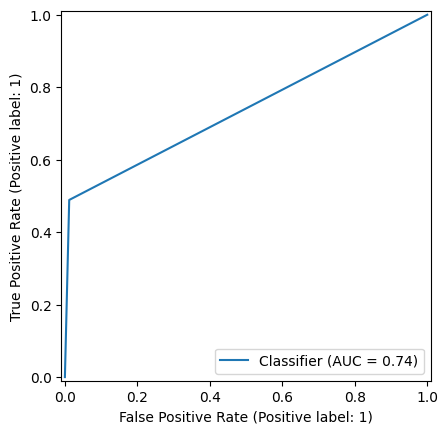

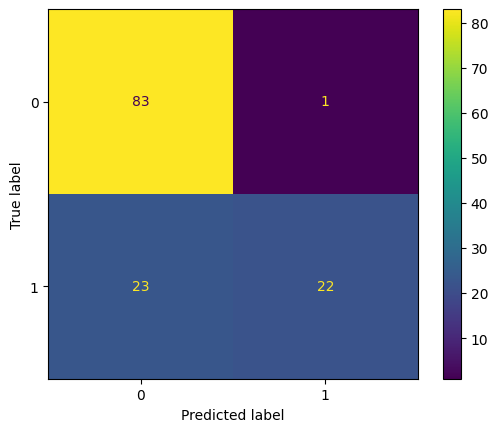

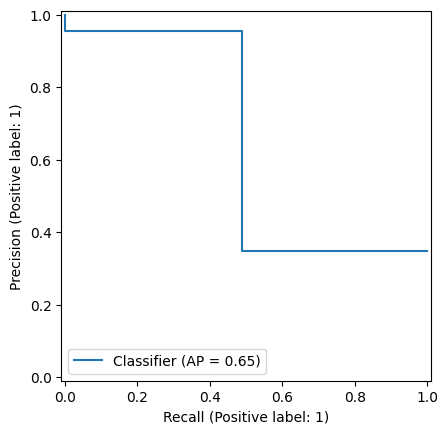

In [ ]:
from sklearn.metrics import (
    RocCurveDisplay,
    ConfusionMatrixDisplay,
    DetCurveDisplay,
    PrecisionRecallDisplay,
    PredictionErrorDisplay,
)

RocCurveDisplay.from_predictions(y_test, predictions)
ConfusionMatrixDisplay.from_predictions(y_test, predictions)
PrecisionRecallDisplay.from_predictions(y_test, predictions)

In [88]:
tree = clf.estimators_
print(tree[0].tree_.max_depth)

12


# Random Forest (hyp-param optimization)

### Get data

In [69]:
rf2 = pd.read_csv(f"data/mgnify_data/{study_id}_combined.csv", index_col=0)

### Split data

In [ ]:
from sklearn.model_selection import train_test_split

X, y = rf2.drop(columns="Health state__elixir"), combined_data["Health state__elixir"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### batch-effect correction

### Imputation

### Normalize

In [ ]:
from sklearn.preprocessing import normalize

X_train = pd.DataFrame(
    normalize(X_train, norm="l1"), index=X_train.index, columns=X_train.columns
)
display(X_train.describe())


,mitochondrion inheritance,mitochondrial genome maintenance,vacuole inheritance,single strand break repair,phosphopyruvate hydratase complex,mannosyltransferase activity,transition metal ion transport,autophagosome assembly,tRNA binding,fatty-acyl-CoA binding,...,Lys48-specific deubiquitinase activity,queuosine salvage,acetolactate synthase regulator activity,CST complex,ribonucleoprotein complex,drug transmembrane export,positive regulation of stomatal complex development,negative regulation of microtubule motor activity,starch binding,regulation of store-operated calcium entry
count,5.150000e+02,5.150000e+02,5.150000e+02,5.150000e+02,515.000000,515.000000,515.000000,5.150000e+02,515.000000,515.000000,...,5.150000e+02,515.000000,515.000000,5.150000e+02,5.150000e+02,5.150000e+02,5.150000e+02,5.150000e+02,515.000000,515.0
mean,2.981392e-07,1.373685e-07,1.952650e-07,6.756082e-08,0.000089,0.000012,0.000048,1.444029e-08,0.001326,0.000004,...,3.893791e-08,0.000096,0.000037,2.745876e-08,1.268317e-07,8.831098e-07,1.916115e-08,1.364667e-08,0.000066,0.0
std,3.205914e-06,1.375062e-06,2.961540e-06,1.455620e-06,0.000051,0.000028,0.000047,3.277023e-07,0.000275,0.000012,...,4.823760e-07,0.000059,0.000035,4.682865e-07,1.441612e-06,4.865025e-06,3.074266e-07,1.710181e-07,0.000051,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000425,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000064,0.000000,0.000020,0.000000e+00,0.001185,0.000000,...,0.000000e+00,0.000061,0.000015,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000031,0.0
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000084,0.000004,0.000038,0.000000e+00,0.001315,0.000000,...,0.000000e+00,0.000092,0.000031,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000057,0.0
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000107,0.000013,0.000064,0.000000e+00,0.001431,0.000001,...,0.000000e+00,0.000123,0.000050,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000094,0.0
max,6.384473e-05,1.941804e-05,6.531679e-05,3.300984e-05,0.000428,0.000374,0.000428,7.436748e-06,0.004587,0.000098,...,9.709021e-06,0.000428,0.000286,1.040420e-05,2.376652e-05,8.218277e-05,5.132943e-06,3.048279e-06,0.000321,0.0


### hyper-param optimization

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np

rf_param_grid = {
    "n_estimators": [25, 50, 100, 200],
    "max_depth": [None, 5, 11, 14],
    "max_features": ["sqrt", "log2", None],
    "min_samples_leaf": [1, 5, 10],
    "bootstrap": [True, False],
}

rf = RandomForestClassifier(random_state=None)
rf_grid = GridSearchCV(
    rf,
    rf_param_grid,
    cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
    n_jobs=-1,
    verbose=2,
)

rf_grid.fit(X_train, y_train)

print(rf_grid.best_params_)
print(rf_grid.best_score_)
print(rf_grid.best_estimator_)
cv_results = pd.DataFrame(rf_grid.cv_results_)
display(cv_results)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 50}
0.7961165048543689
RandomForestClassifier(bootstrap=False, n_estimators=50)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.572528,0.022592,0.042935,0.002163,True,None,sqrt,1,25,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.718447,0.766990,0.737864,0.718447,0.757282,0.739806,0.019802,87
1,1.011184,0.034655,0.042037,0.001673,True,None,sqrt,1,50,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.728155,0.728155,0.718447,0.718447,0.757282,0.730097,0.014269,116
2,1.902609,0.070439,0.048522,0.002893,True,None,sqrt,1,100,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.786408,0.728155,0.757282,0.708738,0.766990,0.749515,0.027734,59
3,3.582257,0.138673,0.060016,0.006624,True,None,sqrt,1,200,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.766990,0.757282,0.718447,0.718447,0.757282,0.743689,0.020913,79
4,0.459268,0.029157,0.040510,0.004674,True,None,sqrt,5,25,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.737864,0.718447,0.757282,0.689320,0.747573,0.730097,0.024096,116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,147.965213,7.689191,0.056772,0.003665,False,14,None,5,200,"{'bootstrap': False, 'max_depth': 14, 'max_fea...",0.640777,0.660194,0.669903,0.601942,0.640777,0.642718,0.023301,259
284,16.704995,1.475549,0.038462,0.006221,False,14,None,10,25,"{'bootstrap': False, 'max_depth': 14, 'max_fea...",0.592233,0.650485,0.660194,0.621359,0.582524,0.621359,0.030702,286
285,29.296117,2.602178,0.036495,0.001847,False,14,None,10,50,"{'bootstrap': False, 'max_depth': 14, 'max_fea...",0.592233,0.650485,0.660194,0.631068,0.582524,0.623301,0.030946,275
286,61.256146,2.859856,0.050199,0.004578,False,14,None,10,100,"{'bootstrap': False, 'max_depth': 14, 'max_fea...",0.592233,0.650485,0.660194,0.631068,0.582524,0.623301,0.030946,275


In [93]:
cv_results.to_csv(f"data/mgnify_data/{study_id}_hyper_param_cv_results.csv")

In [ ]:
cv_results = pd.read_csv(
    f"data/mgnify_data/{study_id}_hyper_param_cv_results.csv", index_col=0
)
cv_results = cv_results.sort_values(by="rank_test_score", ascending=True)
display(cv_results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
145,1.703445,0.034717,0.055627,0.003795,False,NaN,sqrt,1,50,"{'bootstrap': False, 'max_depth': None, 'max_f...",0.796117,0.796117,0.796117,0.776699,0.815534,0.796117,0.012281,1
253,1.213824,0.029453,0.041075,0.005126,False,14.0,sqrt,1,50,"{'bootstrap': False, 'max_depth': 14, 'max_fea...",0.796117,0.786408,0.825243,0.757282,0.786408,0.790291,0.021796,2
254,2.594804,0.077046,0.046814,0.002334,False,14.0,sqrt,1,100,"{'bootstrap': False, 'max_depth': 14, 'max_fea...",0.825243,0.796117,0.786408,0.737864,0.766990,0.782524,0.029191,3
159,2.325705,0.024574,0.083745,0.005582,False,NaN,log2,1,200,"{'bootstrap': False, 'max_depth': None, 'max_f...",0.825243,0.786408,0.757282,0.737864,0.805825,0.782524,0.031669,3
219,4.699502,0.084620,0.056260,0.004853,False,11.0,sqrt,1,200,"{'bootstrap': False, 'max_depth': 11, 'max_fea...",0.766990,0.834951,0.766990,0.766990,0.776699,0.782524,0.026482,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,51.737013,1.656968,0.041451,0.001673,False,5.0,NaN,10,100,"{'bootstrap': False, 'max_depth': 5, 'max_feat...",0.611650,0.650485,0.650485,0.631068,0.563107,0.621359,0.032492,281
179,114.669200,6.420937,0.046968,0.002607,False,NaN,NaN,10,200,"{'bootstrap': False, 'max_depth': None, 'max_f...",0.582524,0.650485,0.660194,0.631068,0.582524,0.621359,0.033067,281
284,16.704995,1.475549,0.038462,0.006221,False,14.0,NaN,10,25,"{'bootstrap': False, 'max_depth': 14, 'max_fea...",0.592233,0.650485,0.660194,0.621359,0.582524,0.621359,0.030702,286
177,33.148404,4.800651,0.039236,0.004190,False,NaN,NaN,10,50,"{'bootstrap': False, 'max_depth': None, 'max_f...",0.592233,0.650485,0.660194,0.621359,0.582524,0.621359,0.030702,286


### Model fitting

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)

clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

### evaluation

In [ ]:
from sklearn.metrics import classification_report

X_test = pd.DataFrame(
    normalize(X_test, norm="l1"), index=X_test.index, columns=X_test.columns
)
y_test = le.transform(y_test)
predictions = clf.predict(X_test)


In [ ]:
print(classification_report(y_test, predictions, target_names=le.classes_))

              precision    recall  f1-score   support

    Diseased       0.78      0.99      0.87        84
     Healthy       0.96      0.49      0.65        45

    accuracy                           0.81       129
   macro avg       0.87      0.74      0.76       129
weighted avg       0.84      0.81      0.79       129



In [ ]:
print(y_test.sum())
print(len(y_test))

45
129


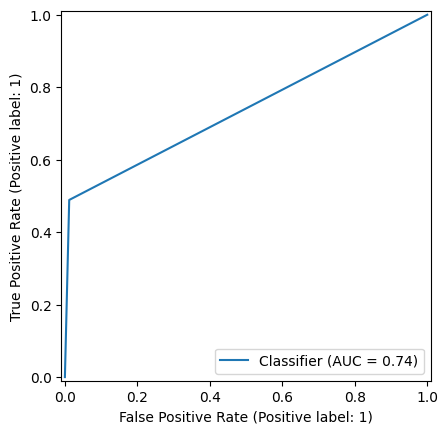

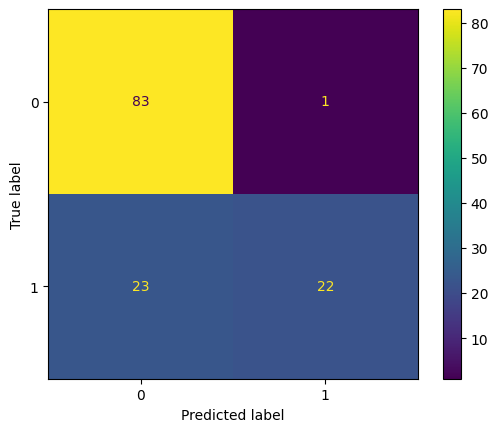

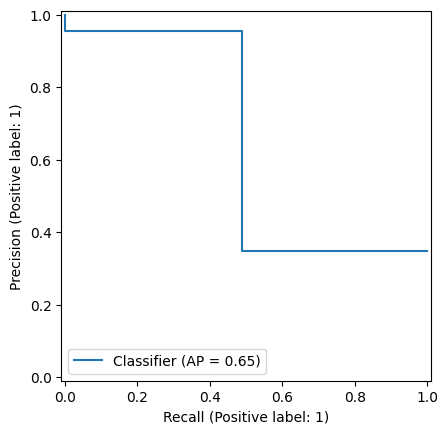

In [ ]:
from sklearn.metrics import (
    RocCurveDisplay,
    ConfusionMatrixDisplay,
    DetCurveDisplay,
    PrecisionRecallDisplay,
    PredictionErrorDisplay,
)

RocCurveDisplay.from_predictions(y_test, predictions)
ConfusionMatrixDisplay.from_predictions(y_test, predictions)
PrecisionRecallDisplay.from_predictions(y_test, predictions)